# Analysis 2: Foundations of modeling 2
## Probabilistic optimization

In this notebook we present the general idea of applying a randomized search to find optimal (i.e. minimal or maximal) values of functions.  We will also introduce a genetic idea to sometimes proceed a search with worse values in order to reach improved values in the end.  The random search presented here is closely related to an optimization scheme called [Hill Climbing](https://en.wikipedia.org/wiki/Hill_climbing).

Everything is illustrated using a simple mathematical function, but the general principles can be applied in a much broader context.

This document contains:
- [Minima of a function](#minima)
- [Randomized search for minima](#randomized)
- [Improvement: allowing bad mutations to survive](#survive)

---
<a id='minima'></a>
### Minima of a function

Probablistic optimization can be used to find minima (and maxima) of a function.  We shall illustrate this by means of an example: 

$$f(x) = x^4-3x^2+x+1.$$

Let us use matplotlib to plot the graph of this function on the interval $[-2, 2]$:

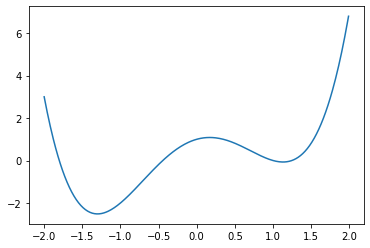

In [1]:
import matplotlib.pyplot as plt

def floatrange(a, b, step=0.01):
    result = []
    x = a
    while x < b:
        result.append(x)
        x += step
    return result

f = lambda x: x**4 - 3*x**2 + x + 1
X = floatrange(-2, 2)
Y = [f(x) for x in X]

plt.plot(X, Y)
plt.show()

We can see that there is a mininum between $-1.5$ and $-1.0$, a minimum between $1.0$ and $1.5$, and a maximum around $0.0$.  The leftmost minimum is a **global** minimum: it is the lowest point on the graph.  The rightmost minimum is a **local** minimum: all points _directly_ around it are higher, but away from it we have points that lie lower.

**Question.** Is the maximum around $0.0$ local or global?

---
<a id='randomized'></a>
### Randomized search for minima
Using a graph we can roughly see where our minima lie, but often we want more accurate values.
We could use calculus to find accurate values of minima,
but not all functions are suited for calculus (our function $f$ is, though).  Instead, we shall use a randomized search.

We keep focusing on the interval $[-2, 2]$ and choose a random $x$-value on there.  Let us also plot the corresponding point in the graph:

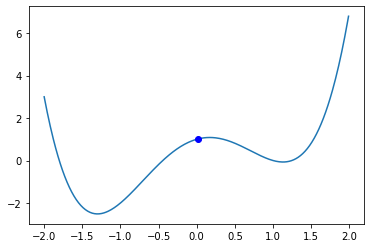

In [2]:
import random

x = random.uniform(-2, 2)

plt.plot(X, Y)  # This is the graph of the function computed above
plt.plot(x, f(x), "bo")  # Randomly chosen point on the graph
plt.show()

Unless we're extremely lucky, the random point is not at one of the minima.
The next step is to slightly change (_"mutate"_) the value of $x$ and hope we end up at a lower point on the graph:

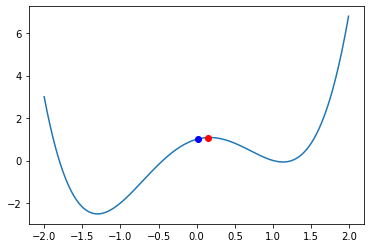

In [3]:
max_delta = 0.5  # Maximum amount by which we want to change x
delta_x = random.uniform(-max_delta, max_delta)  # Actual amount by which we change x, randomly chosen
mutated_x = x + delta_x 

# Make sure the new x stays within [-2, 2]:
if mutated_x < -2: mutated_x = -2
if mutated_x > 2: mutated_x = 2

plt.plot(X, Y)  # Plot f
plt.plot(x, f(x), "bo")  # Old point in blue
plt.plot(mutated_x, f(mutated_x), "ro")  # New point in red
plt.show()

#### Experiment:
- Execute the code cell above a few times, and observe that the red point sometimes ends up higher than the blue point and sometimes lower.

Since we want to find a minimum, we will replace the old blue point with the new red point if it is indeed lower.  Otherwise, we will simply keep using the blue point as our best approximation so far:

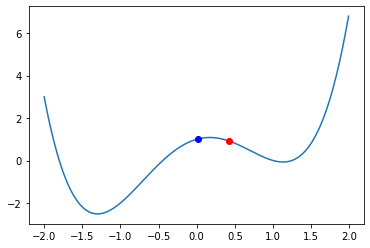

In [4]:
max_delta = 0.5  # Maximum amount by which we want to change x
delta_x = random.uniform(-max_delta, max_delta)  # Actual amount by which we change x, randomly chosen
mutated_x = x + delta_x

# Make sure the new x stays within [-2, 2]:
if mutated_x < -2: mutated_x = -2
if mutated_x > 2: mutated_x = 2

# First plot both points:
plt.plot(X, Y)  # Plot f
plt.plot(x, f(x), "bo")  # Old point in blue
plt.plot(mutated_x, f(mutated_x), "ro")  # New point in red
plt.show()

# Now replace the old point if the new point is better:
if f(mutated_x) < f(x):
    x = mutated_x

#### Experiment:
- Execute the above code cell a couple of times, and observe that the blue point gradually converges towards one of the minima.
- Repeat this experiment several times with different starting points:

In [5]:
x = random.uniform(-2, 2)  # New starting point to use in above experiment

Now that we've got some feeling of how the randomized search works, we will use a for-loop to perform the iteration for us, instead of repeatedly executing the code by hand.  And let us also put the code in a decent function instead of global scope.

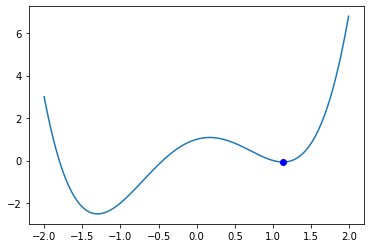

x-value for minimum found: 1.1309589899608206


In [6]:
def find_minimum(f, min_x=-2, max_x=2, max_delta=0.5, steps=10000):
    """Find and return a value x in [min_x, max_x] that is a minimum for f"""
    x = random.uniform(min_x, max_x)
    for _ in range(steps):
        delta_x = random.uniform(-max_delta, max_delta) 
        mutated_x = x + delta_x
        if mutated_x < min_x: mutated_x = min_x
        if mutated_x > max_x: mutated_x = max_x
        if f(mutated_x) < f(x):
            x = mutated_x
    return x

x = find_minimum(f)
plt.plot(X, Y)  
plt.plot(x, f(x), "bo")  
plt.show()
print("x-value for minimum found:", x)

#### Experiment:
- Execute the above code several times, and observe that sometimes we find the leftmost minimum and sometimes the rightmost minimum.
- Use the code to find minima for other functions than our $f$.
- Change the above code to find a maximum of a function.

---
<a id='survive'></a>
### Improvement: allowing bad mutations to survive

The above code is simple and straightforward.  However, it often finds a _local_ minimum, while we sometimes really wish to find a _global_ minimum.  For our simple function $f$, we can find a global minimum by re-running the code lots of times, but most functions are too complex for this approach to work.

Instead we take another approach: we sometimes do continue with the mutated $x$ if it gives a higher function value.
So we set a _survival rate_, typically around $1\%$, i.e. $0.01$.  Every time the mutated $x$ is worse than the old $x$, we draw a random number between $0$ and $1$, and if it is below the survival rate, we continu with the mutated $x$ anyway. 

The idea behind this is that the survival of bad mutations enables us to move away from local minima, so we won't get stuck there.

In code this may look like this:

In [7]:
# Let us first reset parameters, just in case some of them got screwed up.

f = lambda x: x**4 - 3*x**2 + x + 1
X = floatrange(-2, 2)
Y = [f(x) for x in X]
max_delta = 1.0  # We make it a bit bigger now, to really get away from the local minimum

x = random.uniform(-2, 2)  # And choose a starting point again

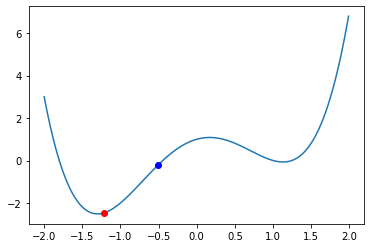

In [8]:
# This cell can be executed repeatedly.

survival_rate = 0.25  # This value is often too high in practice, but helps to explain the idea

delta_x = random.uniform(-max_delta, max_delta) 
mutated_x = x + delta_x
if mutated_x < -2: mutated_x = -2
if mutated_x > 2: mutated_x = 2

plt.plot(X, Y)  # Plot f
plt.plot(x, f(x), "bo")  # Old point in blue
plt.plot(mutated_x, f(mutated_x), "ro")  # Mutation in red
plt.show()

if f(mutated_x) < f(x) or random.random() < survival_rate:  # Note the survival opportunity!
    x = mutated_x  # x may be worse than before, but that is precisely the trick!

#### Experiment:
- Execute the above code cell many times repeatedly, and observe that the blue point sometimes moves away from the minimum.

Since we do move away from a minimum every once in a while, we add a variable to keep track of the best $x$ found so far:

In [9]:
x = random.uniform(-2, 2)  # Start with a new point
best_x = x  # The starting x is the best so far

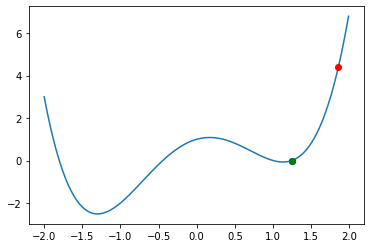

In [10]:
# This cell can be executed repeatedly.

survival_rate = 0.25

delta_x = random.uniform(-max_delta, max_delta) 
mutated_x = x + delta_x
if mutated_x < -2: mutated_x = -2
if mutated_x > 2: mutated_x = 2

if f(mutated_x) < f(best_x):
    best_x = mutated_x  # Though x may get worse, best_x will always improve here.

plt.plot(X, Y)  # Plot f
plt.plot(x, f(x), "bo")  # Old point in blue
plt.plot(mutated_x, f(mutated_x), "ro")  # Mutation in red
plt.plot(best_x, f(best_x), "go")  # Best point in green
plt.show()

if f(mutated_x) < f(x) or random.random() < survival_rate:
    x = mutated_x 

#### Experiment:
- Execute the above code repeatedly, and observe:
    - The "best-so-far" green point gradually converges to a minimum.
    - The green point sometimes covers the blue or red point: in that case the two points are just equal.
    - The blue point often moves towards a minimum, but sometimes moves away from it.

Let us now put everything together in a nice function that uses a for-loop:

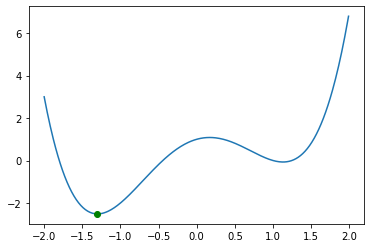

x-value for minimum found: -1.3009957241420242


In [11]:
def find_global_minimum(f, min_x=-2, max_x=2, max_delta=1.0, survival_rate=0.1, steps=25000):
    """Find and return a value x in [min_x, max_x] that is a minimum for f.
    
    This function attempts to find a minimum that is global rather than just local.
    """
    x = random.uniform(min_x, max_x)
    best_x = x
    for _ in range(steps):
        delta_x = random.uniform(-max_delta, max_delta) 
        mutated_x = x + delta_x
        if mutated_x < min_x: mutated_x = min_x
        if mutated_x > max_x: mutated_x = max_x
        if f(mutated_x) < f(best_x):
            best_x = mutated_x
        if f(mutated_x) < f(x) or random.random() < survival_rate:
            x = mutated_x
    return best_x

x = find_global_minimum(f)
plt.plot(X, Y)  
plt.plot(x, f(x), "go")  
plt.show()
print("x-value for minimum found:", x)

Note that in order to make things work, we have increased the default values for `max_delta` and `steps`.  This increases the chance of actually getting kicked away from the local minimum.

#### Experiment:
- Execute the above code several times, and observe that we almost always find the leftmost minimum, which is a global minimum.
- Use the code to find global minima for other functions than our $f$.
- Change the above code to find a global maximum of a function.